![NeuronUnit Logo](https://raw.githubusercontent.com/scidash/assets/master/logos/neuronunit.png)
# Chapter 2
Back to [Chapter 1](chapter1.ipynb)

In the first chapter we used a dummy model and simple test to illustrate some basic concepts.  Here we'll use NeuronUnit in a more interesting way: let's validate a real ion channel model's IV (current vs voltage) curve against data from a published experiment.

In [1]:
import os
import sys
# Get ChannelWorm at http://github.com/openworm/channelworm
CHANNELWORM_HOME = '/Users/rgerkin/Dropbox/dev/openworm/ChannelWorm' # Change this to the location of your ChannelWorm
                                                                     # working copy!
sys.path.insert(1,CHANNELWORM_HOME)
import channelworm # ChannelWorm is available at http://github.com/openworm/channelworm
channelworm.django_setup() # Adds all channelworm subdirectories to the path, including ion_channel.  
from channelworm.ion_channel.models import GraphData # A class to retrieve digitized data from figures.  
from neuronunit.tests.channel import IVCurvePeakTest # A test for the current-voltage relationship 
                                                     # of a neuron or ion channel.
from neuronunit.models.channel import ChannelModel # A SciUnit model class that wraps NeuroML ion channel models.  

### Now let's instantite the ion channel `model`.  
It will be one from a calcium channel whose subunit is thought to be encoded by the EGL-19 gene in C. elegans.

In [2]:
channel_model_name = 'EGL-19.channel' # Name of a NeuroML channel model (corresponds to the name of a NeuroML file).
channel_id = 'ca_boyle' # Identifier for the channel in that NeuroML file.
channel_dir_path = os.path.join(CHANNELWORM_HOME,'models') # Location of NeuroML channel files.  
channel_file_path = os.path.join(channel_dir_path, '%s.nml' % channel_model_name) # Location of the current file.  
model = ChannelModel(channel_file_path, channel_index=0, name=channel_model_name) # Instantiate the model.  
                                                                    # channel_index=0 in most cases, unless there
                                                                    # are multiple channels of the same type
                                                                    # in the model file.  

`ChannelModel` is a NeuronUnit `model` class that wraps an ion channel model expressed using [NeuroML](http://neuroml.org) and simulates its dynamics using [jNeuroML](https://github.com/NeuroML/jNeuroML).  **You should install both.**
### As before, all of the interaction with the model is done through its capabilities.  
In this case, those capabilities are inherited in the `ChannelModel` class definition, and implemented in the methods of that class as defined in `neuronunit.models`.  

Now we get an observation of real ion channel behavior to use for our test:

In [3]:
import quantities as pq

doi = '10.1083/jcb.200203055' # A Digital Object Identifier for (in this case) a journal article.  
fig = '2B' # A reference to a figure in that article.  
sample_data = GraphData.objects.get(graph__experiment__reference__doi=doi, 
                                    graph__figure_ref_address=fig) # If that figure has been digitized by the 
                                                                   # ChannelWorm team, we load its data here.  
obs = list(zip(*sample_data.asarray())) # Reformat this to a raw observation of current density and voltage.  
observation = {'i/C':obs[1]*pq.A/pq.F, 'v':obs[0]*pq.mV} # Make a dictionary with the appropriately valued units.
cell_capacitance = 1e-13 * pq.F # Capacitance is arbitrary if IV curves are scaled.  
observation['i'] = observation['i/C']*cell_capacitance

test = IVCurvePeakTest(observation, scale=True)

DEBUG:django.db.backends:(0.002) QUERY = 'SELECT "ion_channel_graphdata"."id", "ion_channel_graphdata"."graph_id", "ion_channel_graphdata"."series_name", "ion_channel_graphdata"."series_data" FROM "ion_channel_graphdata" INNER JOIN "ion_channel_graph" ON ( "ion_channel_graphdata"."graph_id" = "ion_channel_graph"."id" ) INNER JOIN "ion_channel_experiment" ON ( "ion_channel_graph"."experiment_id" = "ion_channel_experiment"."id" ) INNER JOIN "ion_channel_reference" ON ( "ion_channel_experiment"."reference_id" = "ion_channel_reference"."id" ) WHERE ("ion_channel_reference"."doi" = %s AND "ion_channel_graph"."figure_ref_address" = %s)' - PARAMS = ('10.1083/jcb.200203055', '2B'); args=('10.1083/jcb.200203055', '2B')


Now that we have an observation, we can instantiate our test.  
### How did we know the observation needs the form above?  
It is stated in the tests's docstring, or can be inferred from its optional validate_observation method:
```python
class IVCurveTest(sciunit.Test):
    ...
    def validate_observation(self, observation):
            assert type(observation) is dict
            for item in ['v', 'i']:
                assert item in observation
                assert type(observation[item]) in [list,tuple] \
                    or isinstance(observation[item],np.ndarray)
    ...
```

In [4]:
test = IVCurvePeakTest(observation)

### With the test instantiated, we can now judge the model:

In [5]:
# Judge the model output against the experimental data
score = test.judge(model)
score.summarize()
print("The score was computed according to '%s' with raw value %s and pass cutoff %s" \
    % (score.description,score.raw,test.converter.cutoff))
print('The scaling factor for the model IV curve was %.3g' % score.related_data['scale_factor'])

=== Model EGL-19.channel achieved score Fail on test 'IV Curve Test'. ===
The score was computed according to 'The sum-squared difference in the observed and predicted current values over the range of the tested holding potentials.' with raw value 3.151 and pass cutoff 1.0 pA**2
The scaling factor for the model IV curve was 1


### A `score` object isn't just a number.###
It is also bound to data that allow us to visualize the test result and how the score was reached:

<IPython.core.display.Javascript object>


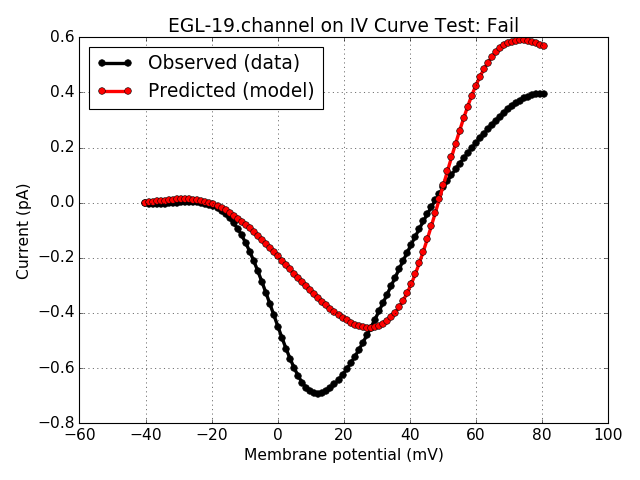

In [6]:
%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update({'font.size':14, 'lines.linewidth':3})
score.plot()
plt.tight_layout()

That's a failing score, because those curves don't look too similar.  What was the criterion for passing?

In [7]:
score.describe()
score.test.converter.description

The sum-squared difference in the observed and predicted current values over the range of the tested holding potentials.


'Converts a score to pass if its value is at most 1.0 pA**2, otherwise False.'

### Let's change the threshold for a passing score:

In [8]:
score.test.converter.cutoff = pq.Quantity(0.1,'pA**2') # Make it easier to pass.  
score = test.converter.convert(score)

Now the score is changed to reflect the new cutoff.  This cutoff is up the person doing the testing!  

In [9]:
score.summarize() # Now shows that the test has passed.  

=== Model EGL-19.channel achieved score Pass on test 'IV Curve Test'. ===


### On to [Chapter 3](chapter3.ipynb)!